In [2]:
import os
import tensorflow as tf
import json
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Conv1D, Dense, LSTM, Dropout, Bidirectional, MaxPooling1D, GlobalAveragePooling1D, AdditiveAttention, SpatialDropout1D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import AdditiveAttention
from datetime import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, classification_report
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.callbacks import EarlyStopping

In [3]:
url_data = 'https://raw.githubusercontent.com/TeodorRusKvi/Tekstanalyse/main/git_NLP_data/'

# Last inn 'X_train_LSTM' fra en CSV-fil
X_df = pd.read_csv(url_data+'X_tensorflow.csv')
# Konverter hele DataFrame til et NumPy array
X = X_df.to_numpy()

# Last inn 'y_train_LSTM' fra en CSV-fil
y_df = pd.read_csv(url_data+'y_liberal.csv')
# Konverter hele DataFrame til et NumPy array
y = y_df.to_numpy()

# Last inn 'y_train_LSTM' fra en CSV-fil
embeddings_GloVe = pd.read_csv(url_data+'embeddings_glove.csv')
# Konverter hele DataFrame til et NumPy array
embeddings_GloVe = embeddings_GloVe.to_numpy()


# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

In [4]:
# Loading the params from CNN-LSTM from the saved JSON-fil
with open('best_trial_1.json', 'r') as f:
    data = json.load(f)
    params = data['params']

In [22]:
def model_build(params, X_train, X_val, y_test, y_val):
    # extracting the parameters
    lstm_units = params['lstm_units']
    dense_1_units = params['dense_1_units']
    dense_2_units = params['dense_2_units']
    dropout_rate = params['dropout_rate']
    learning_rate = params['learning_rate']

    # Model architecture
    input_layer = Input(shape=(20,))
    embedding = Embedding(input_dim=embeddings_GloVe.shape[0],
                          output_dim=embeddings_GloVe.shape[1],
                          weights=[embeddings_GloVe],
                          trainable=False)(input_layer)
    
    spatial_dropout = SpatialDropout1D(0.2)(embedding)
    conv1d = Conv1D(filters=64, kernel_size=1, activation='relu')(spatial_dropout)
    dense = Dense(dense_1_units, activation='relu')(conv1d)
    max_pooling = MaxPooling1D()(dense)
    lstm = Bidirectional(LSTM(lstm_units, activation='tanh', recurrent_activation='sigmoid',
                              recurrent_dropout=0.1, return_sequences=True))(max_pooling)
    
    #Adding a attention layer for potential improvements
    #Using scaling to normalize the values and prevent extreme values 
    attention_layer = AdditiveAttention(use_scale=True)
    attention_output = attention_layer([lstm, lstm], return_attention_scores=False)
    attention_output = GlobalAveragePooling1D()(attention_output)
    
    dense = Dense(dense_2_units, activation='relu')(attention_output)
    dropout = Dropout(dropout_rate)(dense)
    output_layer = Dense(num_classes, activation='sigmoid')(dropout)

    
    model = Model(inputs=input_layer, outputs=output_layer)
    model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate), metrics=['accuracy'])
    
    return model

In [23]:
input_length = 20
num_classes = 1
EPOCHS=20
BATCH_SIZE = 32

model = model_build(params, X_train, X_val, y_test, y_val)

early_stopping_callback = EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)


history = model.fit(X_train, y_train,
                    epochs=20,
                    validation_data=(X_val, y_val),
                    batch_size=BATCH_SIZE,
                    callbacks=early_stopping_callback)

Epoch 1/20
282/282 [==============================] - 23s 26ms/step - loss: 0.6044 - accuracy: 0.6763 - val_loss: 0.5542 - val_accuracy: 0.7303
Epoch 2/20
282/282 [==============================] - 6s 20ms/step - loss: 0.5516 - accuracy: 0.7197 - val_loss: 0.5543 - val_accuracy: 0.7396
Epoch 3/20
282/282 [==============================] - 6s 21ms/step - loss: 0.5299 - accuracy: 0.7408 - val_loss: 0.5229 - val_accuracy: 0.7453
Epoch 4/20
282/282 [==============================] - 6s 20ms/step - loss: 0.5110 - accuracy: 0.7526 - val_loss: 0.5307 - val_accuracy: 0.7448
Epoch 5/20
282/282 [==============================] - 6s 20ms/step - loss: 0.5001 - accuracy: 0.7547 - val_loss: 0.5259 - val_accuracy: 0.7516
Epoch 6/20
282/282 [==============================] - 6s 21ms/step - loss: 0.4912 - accuracy: 0.7633 - val_loss: 0.5440 - val_accuracy: 0.7448


61/61 [==============================] - 1s 8ms/step - loss: 0.5216 - accuracy: 0.7470
Test Loss: 0.5215933322906494
Test Accuracy: 0.7470191717147827


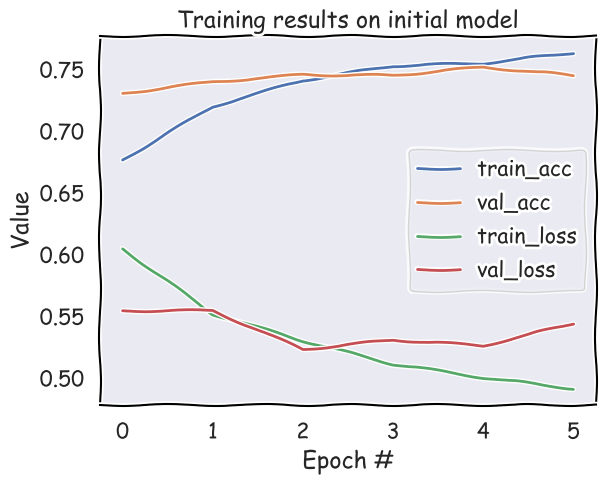

In [24]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test, batch_size=BATCH_SIZE)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

import logging
logging.getLogger('matplotlib.font_manager').disabled = True

with plt.xkcd():
    plt.plot(history.history['accuracy'], label='train_acc')
    plt.plot(history.history['val_accuracy'], label='val_acc')
    plt.plot(history.history['loss'], label='train_loss')
    plt.plot(history.history['val_loss'], label='val_loss')



    plt.xlabel('Epoch #')
    plt.ylabel('Value')
    plt.title('Training results on initial model')
    plt.legend()

    plt.show()

31/31 [==============================] - 2s 10ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.63      0.63      0.63       665
           1       0.81      0.81      0.81      1264

    accuracy                           0.75      1929
   macro avg       0.72      0.72      0.72      1929
weighted avg       0.75      0.75      0.75      1929

Accuracy: 0.7470191809227579
Recall: 0.807753164556962
Precision: 0.806477093206951
F1 Score: 0.8071146245059289


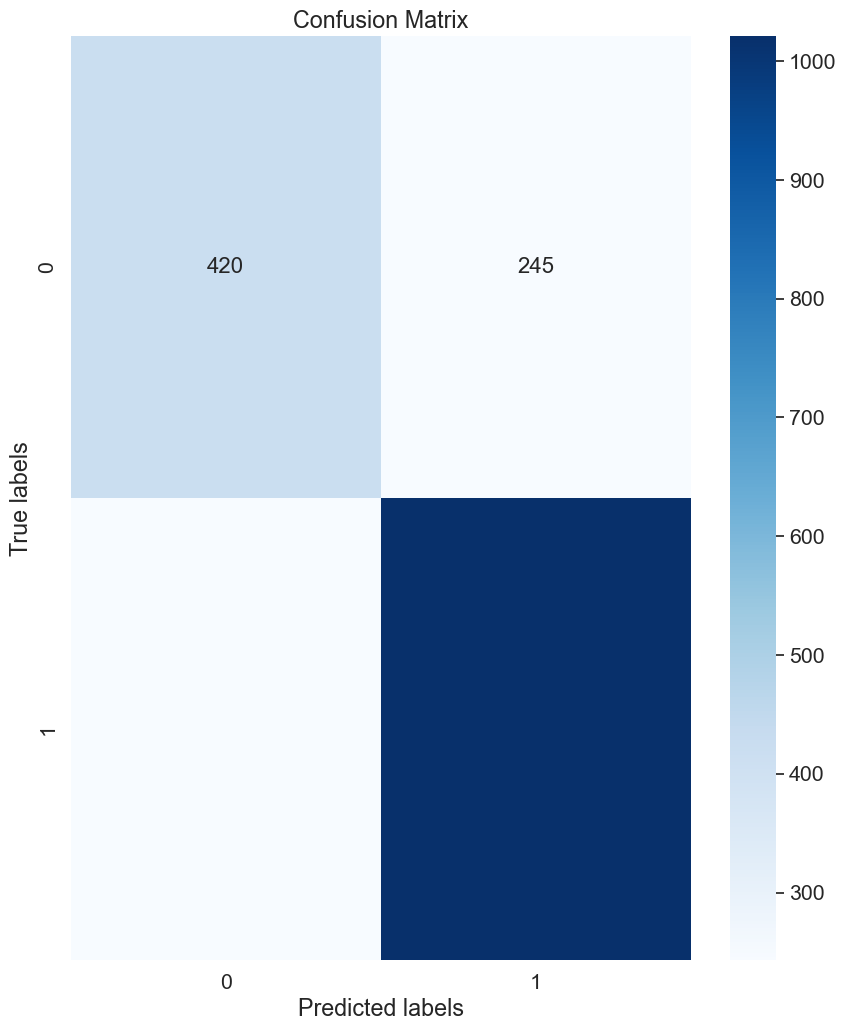

In [25]:
# Predict probabilities for the positive class (class 1)
probabilities = model.predict(X_test, batch_size=64)

# Ensure that probabilities are in the expected format
y_pred = (probabilities > 0.5).astype(int).flatten()

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Calculating different metrics
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Print each metric
print("Accuracy:", accuracy)
print("Recall:", recall)
print("Precision:", precision)
print("F1 Score:", f1)

# Creating a confusion matrix for visualization
cm = confusion_matrix(y_test, y_pred)

# Plotting the confusion matrix
plt.figure(figsize=(10,12))
sns.set(font_scale=1.4)  # for label size
sns.heatmap(cm, annot=True, annot_kws={"size": 16}, fmt='g', cmap='Blues')  # fmt='g' to avoid scientific notation

plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()